#### **Imports**

In [ ]:
## import essential modules 
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import qumcmc 
from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines import quantum_enhanced_mcmc
from qumcmc.basic_utils import plot_bargraph_desc_order, MCMCChain, MCMCState
# from qumcmc.trajectory_processing import trajectory_processing

#### **Define the Energy Model**

In [2]:
# define the model
np.random.seed(6120358)# should always be in the same cell!  
n_spins = 4

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= (n_spins, n_spins) )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.01 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')


            MODEL : my_model
Non-zero Interactions (J) :  12
Non-zero Bias (h) :  4
---------------------------------------------
Average Interaction Strength <J> :  -0.050625000000000045
Average Bias Strength <h>:  0.0075
alpha :  0.7232416972684848
model beta :  1.0
---------------------------------------------


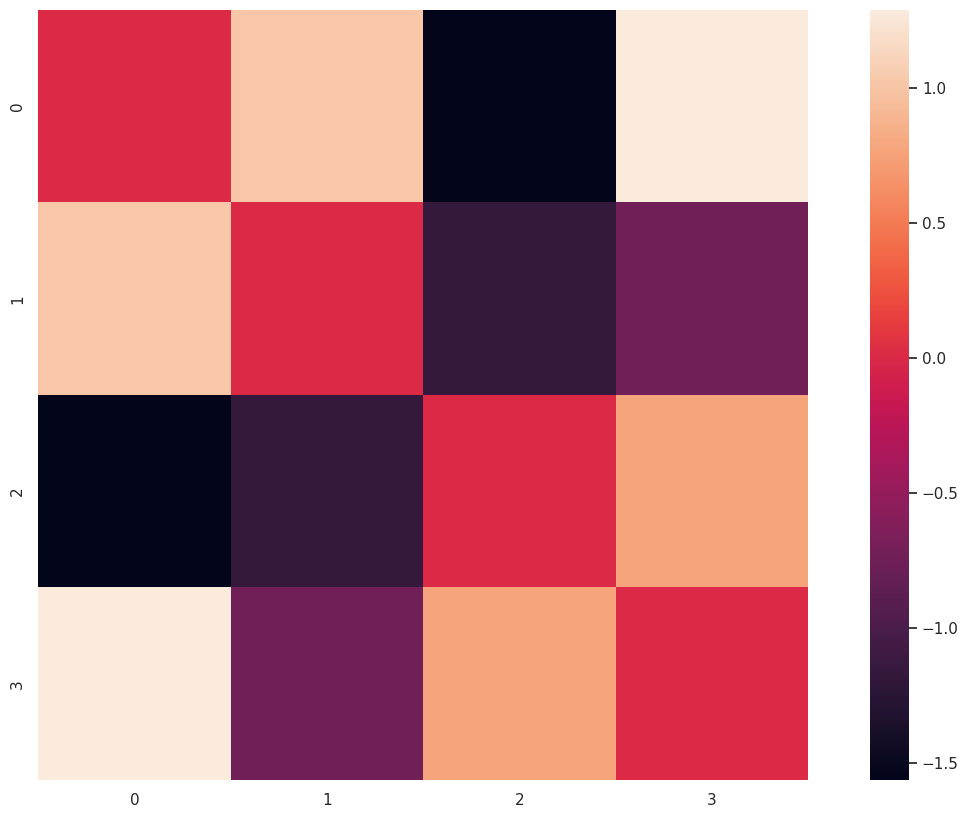

In [3]:
model.model_summary()

#### **Exact Analysis**

In [4]:
import snakeviz
%load_ext snakeviz

In [5]:
## set current beta
beta = 1.100209

## run exact sampling over all possible configurations 
model.run_exact_sampling(beta)

Running Exact Sampling | Model beta :  1.100209


running over all possible configurations: 100%|█| 16/16 [00:00<00:00, 59972.18it

saving distribution to model ...


In [6]:
model.exact_sampling_status

True

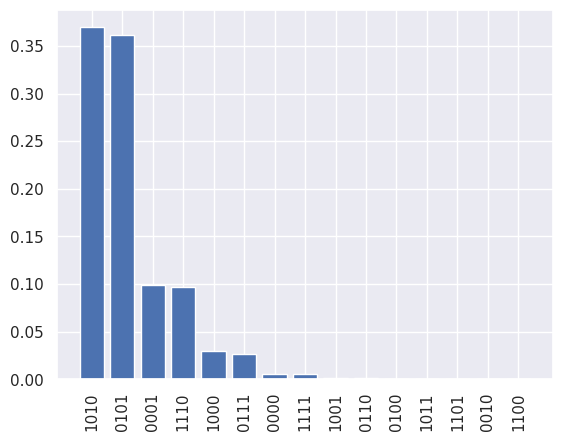

In [7]:
## get the distribution from model
bpd = model.boltzmann_pd

## plot the distribution
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)

#### **Run Classical MCMC**

In [8]:
steps = 50000
mcmc_chain =classical_mcmc(
    n_hops=steps,
    model=model,
    # return_last_n_states=10,
    temperature=1/beta,
)

# trajectory_c = trajectory_processing(accepted_states_c)

starting with:  1110 with energy: -3.011


running MCMC steps ...: 100%|█████████| 50000/50000 [00:00<00:00, 118680.83it/s]


In [11]:
mcmc_chain.get_accepted_dict()

Counter({'1110': 1418,
         '1010': 3123,
         '0101': 3184,
         '0001': 1404,
         '0000': 116,
         '1111': 141,
         '1000': 562,
         '1011': 28,
         '0110': 57,
         '0111': 547,
         '0100': 25,
         '1001': 58,
         '1101': 2,
         '0011': 2,
         '1100': 2})

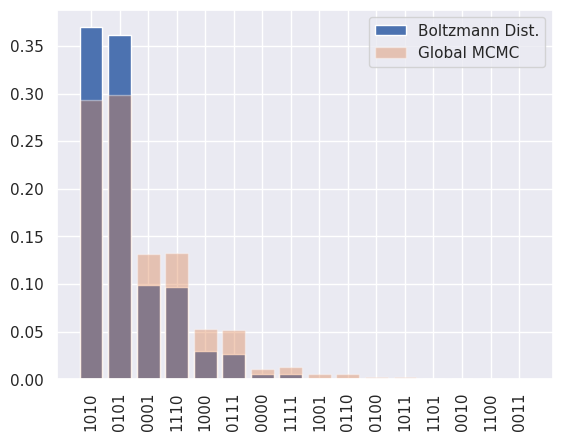

In [13]:
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)
plot_bargraph_desc_order(mcmc_chain.get_accepted_dict(), plot_first_few= -1, normalise_complete_data=True, label= 'Global MCMC', alpha=0.4)
plt.legend()
plt.show()

#### **Run Quantum Enhaned MCMC**

In [29]:
steps = 5000
qamcmc_chain =quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    temperature=1/beta,
)

# trajectory_q = trajectory_processing(accepted_states_q)

starting with:  0110 with energy: 0.6790000000000002
MCMCChain()


runnning quantum MCMC steps . ..: 100%|█████| 5000/5000 [02:16<00:00, 36.72it/s]


In [30]:
qamcmc_chain.get_accepted_dict()

Counter({'0110': 6,
         '1010': 605,
         '0101': 613,
         '1000': 103,
         '1110': 209,
         '0001': 225,
         '0111': 100,
         '0000': 21,
         '0100': 3,
         '1111': 13,
         '1001': 3})

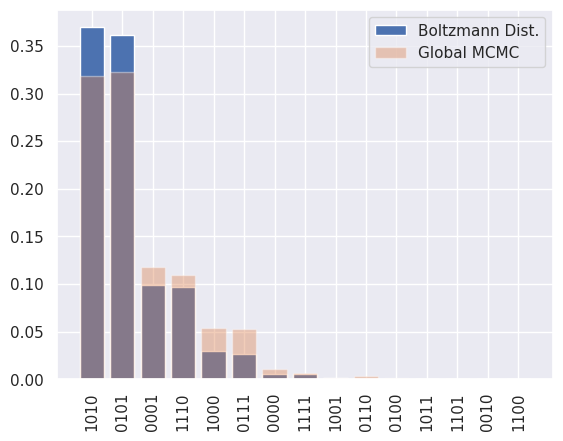

In [31]:
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 15)
plot_bargraph_desc_order(qamcmc_chain.get_accepted_dict(), plot_first_few= -1, normalise_complete_data=True, label= 'Global MCMC', alpha=0.4)
plt.legend()
plt.show()

##### KL Divergence

In [32]:
from tqdm import tqdm
from qumcmc.prob_dist import js_divergence, kl_divergence
def calculate_running_kl_divergence(actual_boltz_distn, mcmc_chain: MCMCChain, skip_steps: int = 1):
    num_nhops = len(mcmc_chain.states)
    
    list_kl_after_each_step=[]

    for step_num in tqdm(range(1, num_nhops, skip_steps)): ##pafloxy : starting at 100 instead of 0 , neglecting effect of intital states

        temp_distn_model = mcmc_chain.get_accepted_dict(normalize=True, until_index=step_num)

        kl_temp=kl_divergence(actual_boltz_distn,temp_distn_model)

        list_kl_after_each_step.append(kl_temp)


    return list_kl_after_each_step

In [33]:
mcmc_chain.get_accepted_dict(normalize=True, until_index=100)

Counter({'1110': 0.3181818181818182,
         '1010': 0.2727272727272727,
         '0101': 0.18181818181818182,
         '0001': 0.045454545454545456,
         '0000': 0.09090909090909091,
         '1111': 0.09090909090909091})

In [34]:
skip_steps = 10

all_classical_kls = calculate_running_kl_divergence(model.boltzmann_pd, mcmc_chain, skip_steps=skip_steps)

all_quantum_kls = calculate_running_kl_divergence(model.boltzmann_pd, qamcmc_chain, skip_steps=skip_steps)

100%|███████████████████████████████████████| 500/500 [00:00<00:00, 4361.57it/s]


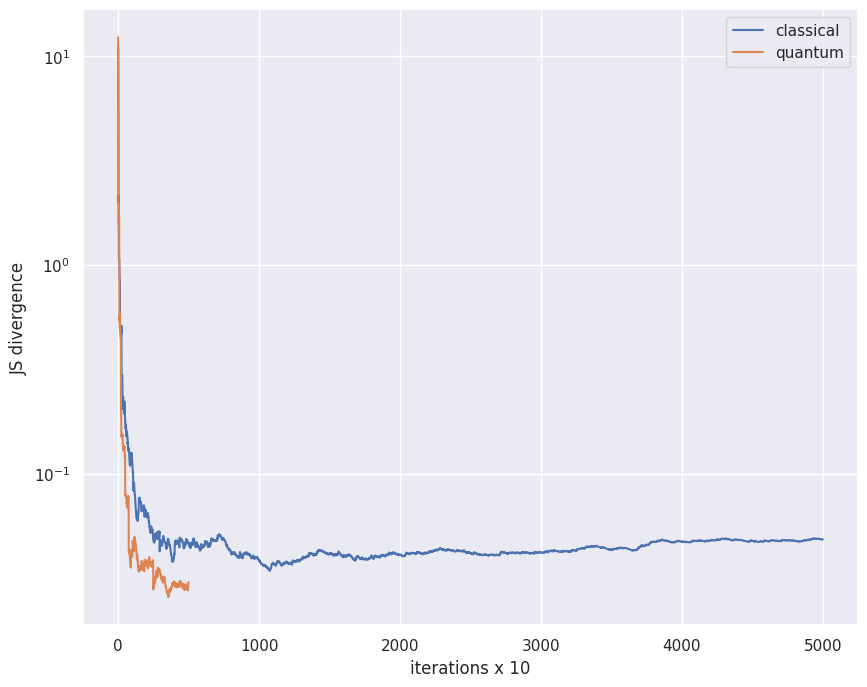

In [35]:
plt.figure(figsize=(10,8))
plt.plot(all_classical_kls, label= 'classical')
plt.plot(all_quantum_kls, label= 'quantum')
plt.xlabel(f"iterations x {skip_steps}")
plt.ylabel("JS divergence")
plt.yscale("log")
plt.legend()
plt.show()
